In [ ]:
###Credit fraud detection model, imbalanced classification
###First model example taken from https://keras.io/examples/structured_data/imbalanced_classification/
###This model is very bad. I want to improve it.
###Code/comments written by me are indicated with triple-###

#Setup
import csv
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
np.random.seed(1262023)

#Vectorize CSV Data
fname = "/content/creditcard.csv"
all_features = []
all_targets = []
with open(fname) as f:
    for i, line in enumerate(f):
        if i == 0:
            print("HEADER:", line.strip())
            continue  # Skip header
        fields = line.strip().split(",")
        all_features.append([float(v.replace('"', "")) for v in fields[:-1]])
        all_targets.append([int(fields[-1].replace('"', ""))])
        if i == 1:
            print("EXAMPLE FEATURES:", all_features[-1])

features = np.array(all_features, dtype="float32")
targets = np.array(all_targets, dtype="uint8")
print("features.shape:", features.shape)
print("targets.shape:", targets.shape)

###Convert seconds into hours for easier binning/analysis
features[:,0] = features[:,0] / 3600

HEADER: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
EXAMPLE FEATURES: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
features.shape: (284807, 30)
targets.shape: (284807, 1)


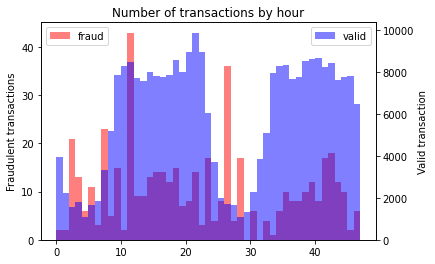

Features pre-shuffle: [[ 0.00000000e+00 -1.35980713e+00 -7.27811754e-02  2.53634667e+00
   1.37815523e+00 -3.38320762e-01  4.62387770e-01  2.39598557e-01
   9.86979008e-02  3.63786966e-01  9.07941684e-02 -5.51599562e-01
  -6.17800832e-01 -9.91389871e-01 -3.11169356e-01  1.46817696e+00
  -4.70400512e-01  2.07971245e-01  2.57905796e-02  4.03992951e-01
   2.51412094e-01 -1.83067787e-02  2.77837574e-01 -1.10473908e-01
   6.69280738e-02  1.28539354e-01 -1.89114839e-01  1.33558378e-01
  -2.10530534e-02  1.49619995e+02]
 [ 0.00000000e+00  1.19185710e+00  2.66150713e-01  1.66480109e-01
   4.48154092e-01  6.00176491e-02 -8.23608115e-02 -7.88029805e-02
   8.51016566e-02 -2.55425125e-01 -1.66974410e-01  1.61272669e+00
   1.06523526e+00  4.89095002e-01 -1.43772289e-01  6.35558069e-01
   4.63917047e-01 -1.14804663e-01 -1.83361277e-01 -1.45783037e-01
  -6.90831318e-02 -2.25775242e-01 -6.38671935e-01  1.01288021e-01
  -3.39846462e-01  1.67170405e-01  1.25894532e-01 -8.98309890e-03
   1.47241689e-02  

In [ ]:
#Preparing Validation Set
###A shuffling step step did not exist in the example model given by the keras.io page, effectively using the first 20% of the observations by time as the
###validation set; the data was trained on transactions from e.g. 1 PM - 5 PM, then validated on transactions from 12 PM - 1 PM. This is a bad assumption if the time of
###the transaction has any effect on spending or fraud habits, which the non-uniform distribution of data points suggests.
bins = np.arange(0,np.ceil(max(features[:,0])),1,dtype=float)
fraud_indices = [i for i, row in enumerate(targets) if row[0]==1]
fraud_features = features[fraud_indices,0]
valid_indices = [i for i, row in enumerate(targets) if row[0]==0]
valid_features = features[valid_indices,0]

fig, ax1 = plt.subplots()
ax1.hist(fraud_features, bins, alpha=0.5, label="fraud", color="red")
ax1.set_ylabel("Fraudulent transactions")
ax2 = ax1.twinx()
ax2.hist(valid_features, bins, alpha=0.5, label="valid", color="blue")
ax2.set_ylabel("Valid transaction")
plt.xlabel("Time")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title("Number of transactions by hour")
plt.show()

shuffled_indices = np.arange(len(features))
np.random.shuffle(shuffled_indices)
features = features[shuffled_indices]
targets = targets[shuffled_indices]
###Features are now shuffled

num_val_samples = int(len(features) * 0.2)
train_features = features[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_features = features[-num_val_samples:]
val_targets = targets[-num_val_samples:]

print("Number of training samples:", len(train_features))
print("Number of validation samples:", len(val_features))

In [ ]:
#Analyze Class Imbalance
counts = np.bincount(train_targets[:, 0])
print(
    "Number of positive samples in training data: {} of {} ({:.3f}% of total)".format(
        counts[1], len(train_targets), 100 * float(counts[1]) / len(train_targets)
    )
)
#set comparative weights for positives and negatives
weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

#Normalize Data Based On Training Set
mean = np.mean(train_features, axis=0)
train_features -= mean
val_features -= mean
std = np.std(train_features, axis=0)
train_features /= std
val_features /= std

#Build Binary Classification Model
model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(train_features.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Number of positive samples in training data: 393 of 227846 (0.172% of total)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                             

In [ ]:
#Train The Model Tith class_weight Argument
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
class_weight = {0: weight_for_0, 1: weight_for_1}

history = model.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,
)

Epoch 1/30
112/112 - 7s - loss: 2.2115e-06 - fn: 44.0000 - fp: 26086.0000 - tn: 201367.0000 - tp: 349.0000 - precision: 0.0132 - recall: 0.8880 - val_loss: 0.1830 - val_fn: 9.0000 - val_fp: 3196.0000 - val_tn: 53666.0000 - val_tp: 90.0000 - val_precision: 0.0274 - val_recall: 0.9091 - 7s/epoch - 67ms/step
Epoch 2/30
112/112 - 5s - loss: 1.4691e-06 - fn: 25.0000 - fp: 10261.0000 - tn: 217192.0000 - tp: 368.0000 - precision: 0.0346 - recall: 0.9364 - val_loss: 0.1898 - val_fn: 9.0000 - val_fp: 3309.0000 - val_tn: 53553.0000 - val_tp: 90.0000 - val_precision: 0.0265 - val_recall: 0.9091 - 5s/epoch - 45ms/step
Epoch 3/30
112/112 - 5s - loss: 1.2542e-06 - fn: 27.0000 - fp: 8369.0000 - tn: 219084.0000 - tp: 366.0000 - precision: 0.0419 - recall: 0.9313 - val_loss: 0.1204 - val_fn: 10.0000 - val_fp: 2633.0000 - val_tn: 54229.0000 - val_tp: 89.0000 - val_precision: 0.0327 - val_recall: 0.8990 - 5s/epoch - 46ms/step
Epoch 4/30
112/112 - 5s - loss: 1.1212e-06 - fn: 23.0000 - fp: 9063.0000 - tn: 

dict_keys(['loss', 'fn', 'fp', 'tn', 'tp', 'precision', 'recall', 'val_loss', 'val_fn', 'val_fp', 'val_tn', 'val_tp', 'val_precision', 'val_recall'])


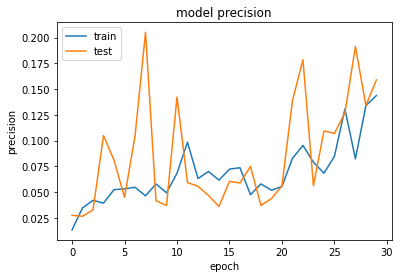

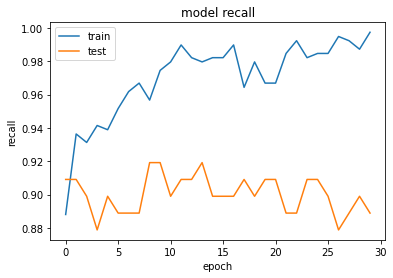

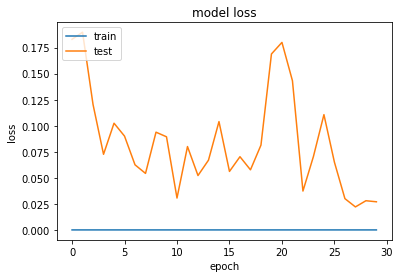

In [ ]:
###Visualize Learning Curve
# list all data in history
print(history.history.keys())
# summarize history for precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for recall
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

###Obvious overfitting, probably due to overparamaterization. Loss function on training set is near zero. Raise lambda